 ### Can you enhance a Stochastic Oscillator to accurately predict stock movement?
 * Brian Cobo
 * Hunter Newton
 * Lim Nguyen

## What Is A Stochastic Oscillator?
A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0-100 bounded range of values.
<img src= "Sample_SO.png" width = "600">
When the oscillator moves above the 80 threshold, or below the 20 threshold, it can be considered overbought or oversold and is likely to move in the opposite.

### The Issue
Stochastic Oscillators by themselves aren't considered accurate and should not be used by themselves because its not a predictor of future stock movement as demonstrated below. 
<img src = "StochOscTradingInitial.png">
However, it does follow a general pattern of when crossing the thresholds, it may move directions. The problem is that stocks in nature are very versatile.

### A Solution?
While trading TSLA stocks with a stochastic Oscillator did end up to a positive return, the majority of the time was spent in the holes and the returns are extremely small. 
So what if we analyzed the volumes of the stock as well as the signals produced by the oscillator? If the oscillator is saying that today is a good time to long or short a stock, and the volume is abnormally high, it makes sense that the extra volume will give the prices the push it needs in the direction implied.

<img src= "Close v Volume.png" width="700">
The graph above shows the average Volume and the Closing price over time. The Closing price seems to be following the Volume closely. When the volume skyrocks an extra ~7 Million trades between 2012 and 2013, the Closing price increases ~$200, and continues to follow the general movement of Volume. We believe this is because volume drives trade and the stochastic oscillator may tell us the direction.

In [205]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'seaborn'

# The stochastic oscillator is calculated using the following formula:

%K = 100(C – L14)/(H14 – L14)

Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K

In [192]:
def create_stochastic_oscillator(stock_data):
    stock_data['L14'] = stock_data['Low'].rolling(window=14).min()
    stock_data['H14'] = stock_data['High'].rolling(window=14).max()
    stock_data['%K'] = 100*((stock_data['Close'] - stock_data['L14']) / (stock_data['H14'] - stock_data['L14']))
    stock_data['%D'] = stock_data['%K'].rolling(window=3).mean()
    return stock_data

In [193]:
def draw_stochastic_oscillator(stock_data):
    fig, axes = plt.subplots(figsize=(20,10))   
    stock_data[['%K','%D']].plot(ax=axes); axes.set_title('Oscillator')
    plt.show()

In [194]:
 def calculate_long_short(stock_data):   
    
    # Create a column showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
    # A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
    stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)

    #Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
    #A sell exit signal is given when the %K line crosses back up through the %D line 
    stock_data['Sell Exit'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) 

    #create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
    stock_data['Short'] = np.nan 
    stock_data.loc[stock_data['Sell Entry'],'Short'] = -1 
    stock_data.loc[stock_data['Sell Exit'],'Short'] = 0 


    #Set initial position on day 1 to flat 
    stock_data['Short'][0] = 0 

    #Forward fill the position column to represent the holding of positions through time 
    stock_data['Short'] = stock_data['Short'].fillna(method='pad') 

    #Create a column in stock_data showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
    #A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
    stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20) 

    #Create a column in stock_data showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
    #A buy exit signal is given when the %K line crosses back down through the %D line 
    stock_data['Buy Exit'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) 


    #create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
    stock_data['Long'] = np.nan  
    stock_data.loc[stock_data['Buy Entry'],'Long'] = 1  
    stock_data.loc[stock_data['Buy Exit'],'Long'] = 0

    #Set initial position on day 1 to flat 
    stock_data['Long'][0] = 0  

    #Forward fill the position column to represent the holding of positions through time 
    stock_data['Long'] = stock_data['Long'].fillna(method='pad') 

    #Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
    stock_data['Position'] = stock_data['Long'] + stock_data['Short']
    
    return stock_data

In [195]:
def draw_long_short(stock_data):
    stock_data['Position'].plot(figsize=(20,10))

In [196]:
def draw_strategy_vs_market_return(stock_data):
    #Set up a column holding the daily Tesla returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()

    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)

    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot()

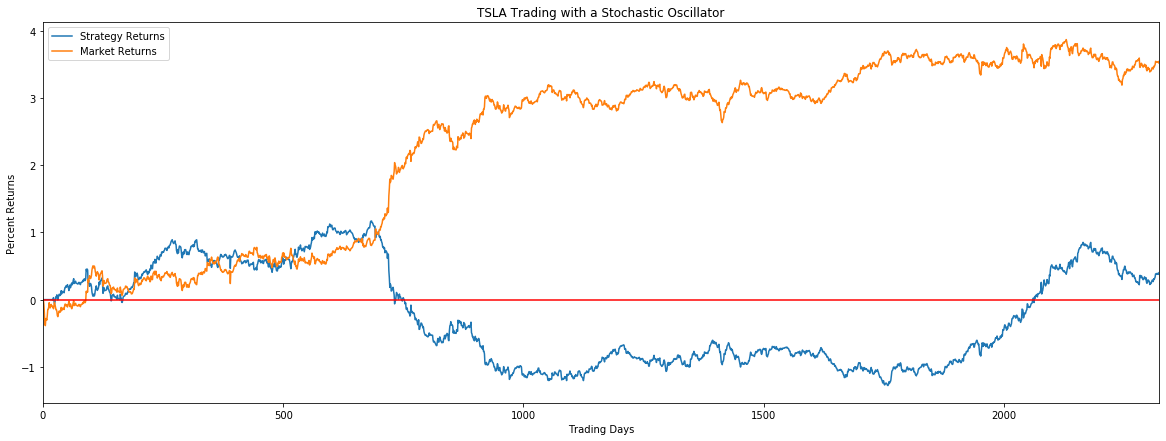

In [202]:
def draw_buy_sell_entry(stock_data):
    stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
    stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20)
    #Create empty "Position" column
    stock_data['Position'] = np.nan 
    #Set position to -1 for sell signals
    stock_data.loc[stock_data['Sell Entry'],'Position'] = -1 
    #Set position to -1 for buy signals
    stock_data.loc[stock_data['Buy Entry'],'Position'] = 1 
    #Set starting position to flat (i.e. 0)
    stock_data['Position'].iloc[0] = 0 
    #Forward fill the position column to show holding of positions through time
    stock_data['Position'] = stock_data['Position'].fillna(method='ffill')
    #Set up a column holding the daily Apple returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()
    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)
    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,7))
    plt.title('TSLA Trading with a Stochastic Oscillator')
    plt.xlabel('Trading Days')
    plt.ylabel('Percent Returns')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()
draw_buy_sell_entry(stock_data)

In [198]:
def draw_predictions(stock_data):
    stock_data['Sell Entry'] = (stock_data.Prediction.shift(1) == -1)  # ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
    stock_data['Buy Entry'] = (stock_data.Prediction.shift(1) == 1)  # ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20)
    #Create empty "Position" column
    stock_data['Position'] = np.nan 
    #Set position to -1 for sell signals
    stock_data.loc[stock_data['Sell Entry'],'Position'] = -1 
    #Set position to -1 for buy signals
    stock_data.loc[stock_data['Buy Entry'],'Position'] = 1 
    #Set starting position to flat (i.e. 0)
    stock_data['Position'].iloc[0] = 0 
    #Forward fill the position column to show holding of positions through time
    stock_data['Position'] = stock_data['Position'].fillna(method='ffill')
    #Set up a column holding the daily Apple returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()
    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)
    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10))
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()
    print('Strategy', stock_data['Strategy Returns'].iloc[-1])
    print('Market', stock_data['Market Returns'].iloc[-1])

    

In [199]:
def make_predictions(stock_data):
    list_vol_avg = [stock_data.iloc[99].Volume]
    vol_avg = int(np.mean(stock_data.iloc[:100].Volume))
    for i in range(100, len(stock_data)):
        q1 = np.percentile(stock_data.iloc[:i].Volume, 25)
        q3 = np.percentile(stock_data.iloc[:i].Volume, 75)
        iqr = (q3 - q1) * 1.1
        if (stock_data.iloc[i].Volume < q1 - iqr) or (stock_data.iloc[i].Volume > q3 + iqr):
            stock_data.set_value(i, 'Outlier', 1)
            
            
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Long == 1):
            #stock_data.iloc[i].Prediction = 1
            stock_data.set_value(i, 'Prediction', 1)
            
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Short == -1):
            #stock_data.iloc[i].Prediction = -1
            stock_data.set_value(i, 'Prediction', -1)
            
        vol_avg = int(np.mean(stock_data.iloc[:i].Volume))
        list_vol_avg.append(vol_avg)
    return stock_data

In [200]:
def main():
    stock_data = pd.read_csv(os.getcwd() + "/Stock_Data/TSLA.csv")
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values(by='Date')
    stock_data = stock_data.dropna()
    stock_data['Outlier'] = 0
    stock_data['Prediction'] = 0
    stock_data.info()
    stock_data.describe()
    stock_data.head()
    stock_data = create_stochastic_oscillator(stock_data)
    stock_data = calculate_long_short(stock_data)
    stock_data = make_predictions(stock_data)
    stock_data.to_csv('TSLA_Stochastic_Oscillator_Dataframe.csv')
    return stock_data
    
stock_data = main()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 9 columns):
Date          2324 non-null datetime64[ns]
Open          2324 non-null float64
High          2324 non-null float64
Low           2324 non-null float64
Close         2324 non-null float64
Adj Close     2324 non-null float64
Volume        2324 non-null int64
Outlier       2324 non-null int64
Prediction    2324 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 181.6 KB


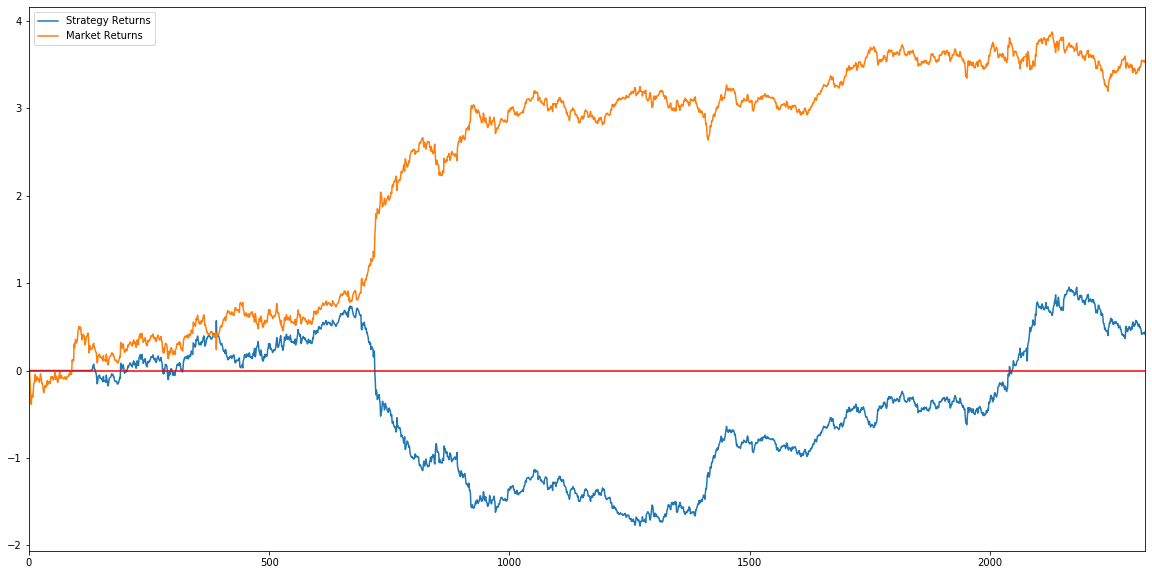

Strategy 0.02424984125912788
Market -0.02424984125912788


In [201]:
draw_predictions(stock_data)